In [0]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.init as init

In [0]:
price = yf.download("AAPL")

[*********************100%***********************]  1 of 1 completed


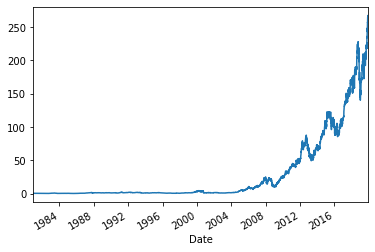

In [0]:
price['Adj Close'].plot()

In [0]:
class MTimeSLoader():
    def __init__(self, price,batch_size,seq_len):
        self.price = price
        self.batch_size = batch_size
        self.seq_len = seq_len

    def RSICalc(self,price):
        delta = price['Adj Close'].diff()
        dUp, dDown = delta.copy(), delta.copy()
        dUp[dUp < 0] = 0
        dDown[dDown > 0] = 0
        RolUp = dUp.rolling(window=14).mean()
        RolDown = dDown.abs().rolling(window=14).mean()
        return np.where(RolDown != 0,RolUp / RolDown,1)

    def getTI(self,price):
        adjustment = price['Adj Close']/price['Close']

        # VOLITILIY
        # Bollinger Bands
        std_20 = price['Adj Close'].rolling(window=20).std() 
        ub = price['Adj Close'] - 2 * std_20
        lb = price['Adj Close'] + 2 * std_20

        # TREND
        # Moving Averages
        ma_10 = price['Adj Close'].rolling(window=10).mean()
        ma_20 = price['Adj Close'].rolling(window=20).mean()

        # Moving Averae Convergence Divergence
        ema_26 = pd.Series.ewm(price['Adj Close'],span=26).mean()
        ema_12 = pd.Series.ewm(price['Adj Close'],span=12).mean()
        macd = ema_26-ema_12

        # MOMENTUM 
        # RSI 
        rsi = self.RSICalc(price)
        return pd.DataFrame({'ma_10':ma_10,'ma_20':ma_20,'macd':macd,'bol_lb':lb,'bol_up':ub, 'rsi':rsi})

    def getFI(self,price):
        return pd.DataFrame({})

    def getFFTComponents(self,price):
        close_fft = np.fft.fft(np.asarray(price['Adj Close'].tolist()))
        fft_df = pd.DataFrame({'fft':close_fft})
        real = fft_df['fft'].apply(lambda x: np.abs(x))
        angle = fft_df['fft'].apply(lambda x: np.angle(x))
        df =  pd.DataFrame(data = {'real':real,'angle':angle})
        df.index = price.index
        return df

    def getFeatures(self,price):
        return pd.concat([price['Adj Close'].pct_change(),]) # self.getTI(price), self.getFI(price), self.getFFTComponents(price)],axis=1)

    def __len__(self):
        return len(self.prices.shape[0])

    def get(self):
        data = self.getFeatures(self.price)[30:]
        filt = data.to_numpy()[self.seq_len:]
        items = filt.shape[0]
        choice = np.random.choice(items, self.batch_size, replace=False)
        return np.vstack([np.vstack([filt[r] for r in range(i-self.seq_len,i)]).reshape(self.seq_len,-1) for i in choice]).reshape(self.batch_size,self.seq_len,-1)


In [0]:
batch_size = 32
window_size = 12
MTimeSLoader(price,batch_size,window_size).get().shape

(32, 12, 1)

In [0]:
def weight_init(m):
    if isinstance(m, nn.Conv1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.Conv3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose1d):
        init.normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose2d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.ConvTranspose3d):
        init.xavier_normal_(m.weight.data)
        if m.bias is not None:
            init.normal_(m.bias.data)
    elif isinstance(m, nn.BatchNorm1d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm2d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.BatchNorm3d):
        init.normal_(m.weight.data, mean=1, std=0.02)
        init.constant_(m.bias.data, 0)
    elif isinstance(m, nn.Linear):
        init.xavier_normal_(m.weight.data)
        init.normal_(m.bias.data)
    elif isinstance(m, nn.LSTM):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.LSTMCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRU):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)
    elif isinstance(m, nn.GRUCell):
        for param in m.parameters():
            if len(param.shape) >= 2:
                init.orthogonal_(param.data)
            else:
                init.normal_(param.data)

In [0]:
class Generator(nn.Module):
    def __init__(self, inp , op,  hi = 512):
        super().__init__()
        self.inp = inp
        self.op = op
        self.lstm = nn.LSTM(inp, hi, 1, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(hi, op) , nn.Tanh())
        self.apply(weight_init)

    def forward(self, inpu , hi = 512):
        h_0 = torch.zeros(1, inpu.size(0), hi)
        c_0 = torch.zeros(1, inpu.size(0), hi)
        outputs, (hn, cn) = self.lstm(inpu, (h_0, c_0))
        op = hn[-1]
        outputs = self.linear(op)
        return outputs


class Discriminator(nn.Module):
    def __init__(self, inp , op,  hi = 512):
        super().__init__()
        self.inp = inp
        self.op = op
        self.lstm = nn.LSTM(inp, hi, 1, batch_first=True)
        self.linear = nn.Sequential(nn.Linear(hi, op) , nn.Sigmoid())
        self.apply(weight_init)

    def forward(self, inpu , hi = 512):
        h_0 = torch.zeros(1, inpu.size(0), hi)
        c_0 = torch.zeros(1, inpu.size(0), hi)
        outputs, (hn, cn) = self.lstm(inpu, (h_0, c_0))
        op = hn[-1]
        outputs = self.linear(op)
        return outputs

In [0]:
def fit_with(lr,eph,noise_size,batch,window):

    nz = int(noise_size)
    num_epochs = int(eph)
    lr = 0.0002
    beta1 = 0.5

    window_size = int(window)
    batch_size = int(batch)
    real_label = 1 
    fake_label = 0
    feature_size = 14

    criterion = nn.BCELoss()
    netD = Discriminator(feature_size,1)
    netG = Generator(nz,window_size*feature_size)

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    sum_err = 0

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):
        sum_err = 0 
        for i in range(10):
          data = MTimeSLoader(price,batch_size,window_size).get()
          real = torch.Tensor(data)
          # maximize log(D(x)) + log(1 - D(G(z)))
          netD.zero_grad()
          b_size = real.size(0)
          label = torch.full((b_size,), real_label)
          if not (real == real).all():
            print(real)
          output = netD(real)
          errD_real = criterion(output.view(-1), label)
          errD_real.backward()
          D_x = output.mean().item()

          noise = torch.randn(b_size, window_size, nz)
          fake = netG(noise)
          label.fill_(fake_label)
          fake = fake.view(b_size,window_size,-1)
          output = netD(fake.detach())
          errD_fake = criterion(output.view(-1), label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()

          # (2) maximize log(D(G(z)))
          netG.zero_grad()
          label.fill_(real_label)  
          output = netD(fake).view(-1)
          errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()
          sum_err = sum_err + errD

          if i % 50 == 0:
              print(f'epoch : {epoch} , iter : {i} , dis err: {errD.item()}  , gen err: {errG.item()} , {D_x}, {D_G_z1}, {D_G_z2}')

          G_losses.append(errG.item())
          D_losses.append(errD.item())
    
  
    print(f"Toral error {sum_err}")
    # The small change: we're only going to return the accuracy
    return sum_err

In [0]:
!pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.0.1-cp36-none-any.whl size=10032 sha256=8b1008a10494a8590b478eacdc609475d3856056604d3f7200f3afe62d7820cc
  Stored in directory: /root/.cache/pip/wheels/1d/0d/3b/6b9d4477a34b3905f246ff4e7acf6aafd4cc9b77d473629b77
Successfully built bayesian-optimization


In [0]:
from bayes_opt import BayesianOptimization

# Bounded region of parameter space
pbounds = {'lr': (1e-4, 1e-2),
           'eph':(10,20),
           'noise_size': (100,200),
           'batch':(32,64),
           'window':(10,20)
           }

optimizer = BayesianOptimization(
    f=fit_with,
    pbounds=pbounds,
    verbose=2,
    random_state=1,
)

optimizer.maximize(init_points=2, n_iter=2,)

for i, res in enumerate(optimizer.res):
    print("Iteration {}: \n\t{}".format(i, res))

print(optimizer.min)

|   iter    |  target   |   batch   |    eph    |    lr     | noise_... |  window   |
-------------------------------------------------------------------------------------
epoch : 0 , iter : 0 , dis err: 1.658155083656311  , gen err: 0.3573344349861145 , 0.7989304661750793, 0.7608800530433655, 0.6995387077331543
epoch : 1 , iter : 0 , dis err: 0.3818158805370331  , gen err: 1.92586088180542 , 0.8308852314949036, 0.17688436806201935, 0.14575038850307465
epoch : 2 , iter : 0 , dis err: 0.19441628456115723  , gen err: 3.46313738822937 , 0.855465292930603, 0.03623412176966667, 0.03133133053779602
epoch : 3 , iter : 0 , dis err: 0.15336377918720245  , gen err: 4.577373504638672 , 0.8682558536529541, 0.011395626701414585, 0.01028186921030283
epoch : 4 , iter : 0 , dis err: 0.10977791994810104  , gen err: 5.378658294677734 , 0.9010883569717407, 0.005010060500353575, 0.004614008590579033
epoch : 5 , iter : 0 , dis err: 0.0854015052318573  , gen err: 6.066752910614014 , 0.9208036065101624, 0.00

AttributeError: ignored

In [0]:
#Pass the learnt bayesian parameters into this

def train(lr,eph,noise_size,batch,window):

    nz = int(noise_size)
    num_epochs = int(eph)
    lr = 0.0002
    beta1 = 0.5

    window_size = int(window)
    batch_size = int(batch)
    real_label = 1 
    fake_label = 0
    feature_size = 1

    criterion = nn.BCELoss()
    netD = Discriminator(feature_size,1)
    netG = Generator(nz,window_size*feature_size)

    optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
    optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

    img_list = []
    G_losses = []
    D_losses = []
    iters = 0
    sum_err = 0

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):
        sum_err = 0 
        for i in range(10):
          data = MTimeSLoader(price,batch_size,window_size).get()
          real = torch.Tensor(data)
          # maximize log(D(x)) + log(1 - D(G(z)))
          netD.zero_grad()
          b_size = real.size(0)
          label = torch.full((b_size,), real_label)
          if not (real == real).all():
            print(real)
          output = netD(real)
          errD_real = criterion(output.view(-1), label)
          errD_real.backward()
          D_x = output.mean().item()

          noise = torch.randn(b_size, window_size, nz)
          fake = netG(noise)
          label.fill_(fake_label)
          fake = fake.view(b_size,window_size,-1)
          output = netD(fake.detach())
          errD_fake = criterion(output.view(-1), label)
          errD_fake.backward()
          D_G_z1 = output.mean().item()
          errD = errD_real + errD_fake
          optimizerD.step()

          # (2) maximize log(D(G(z)))
          netG.zero_grad()
          label.fill_(real_label)  
          output = netD(fake).view(-1)
          errG = criterion(output, label)
          errG.backward()
          D_G_z2 = output.mean().item()
          optimizerG.step()
          sum_err = sum_err + errD

          if i % 50 == 0:
              print(f'epoch : {epoch} , iter : {i} , dis err: {errD.item()}  , gen err: {errG.item()} , {D_x}, {D_G_z1}, {D_G_z2}')

          G_losses.append(errG.item())
          D_losses.append(errD.item())
    
    return netG

In [0]:
netG = train(0.0001,20,150,32,12)

epoch : 0 , iter : 0 , dis err: 1.8006501197814941  , gen err: 1.3055551052093506 , 0.20896044373512268, 0.2094605565071106, 0.27102208137512207
epoch : 1 , iter : 0 , dis err: 1.3870536088943481  , gen err: 0.6999809741973877 , 0.5013543963432312, 0.5017291903495789, 0.49659475684165955
epoch : 2 , iter : 0 , dis err: 1.3810667991638184  , gen err: 0.6980000734329224 , 0.5004507899284363, 0.49783211946487427, 0.4975794553756714
epoch : 3 , iter : 0 , dis err: 1.395916223526001  , gen err: 0.6902440786361694 , 0.4966202974319458, 0.5014177560806274, 0.501453697681427
epoch : 4 , iter : 0 , dis err: 1.3815889358520508  , gen err: 0.6968743205070496 , 0.5011410713195801, 0.4987855553627014, 0.4981399178504944
epoch : 5 , iter : 0 , dis err: 1.3863903284072876  , gen err: 0.6967782378196716 , 0.49898210167884827, 0.4990280568599701, 0.49818775057792664
epoch : 6 , iter : 0 , dis err: 1.3659768104553223  , gen err: 0.7057017087936401 , 0.5047994256019592, 0.4945886433124542, 0.493761956691

In [0]:
latent = torch.randn(10000, 12, 150)
dat = netG(latent)
dat = dat.view(10000,12,-1)

In [0]:
rets = []
for i in range(10000):
  rets.append(dat[i][-1][0].item())